In [17]:
import numpy as np
import pandas as pd
import os
import pathlib

# data viz
from matplotlib import pyplot as plt
import seaborn as sns           # for nicer plots
sns.set(style="darkgrid")       # default style

# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# tf
import tensorflow as tf
from tensorflow.keras import initializers

# Step 1: Data Ingestion

Available at `02-choose-trgt-and-preprocess-imputemeansubgr-smotenc-sa.ipynb` notebook

# Step 2: Data Preprocessing

Available at `02-choose-trgt-and-preprocess-imputemeansubgr-smotenc-sa.ipynb` notebook

# Step 3: Exploratory Data Analysis

Available at `03-eda-imputemeansubgr-smotenc-sa.ipynb` notebook

# Step 4: Consider Feature Selection

Exploration of feature selection using pearson correlation and feature importance are available in `04-feature-select-imputemeansubgr-smontenc-sa.ipynb` notebook. Since we have over 51,500 samples to feature ratio, we will use all features from Step 2 in model building.

# Step 5: Modeling (Multiclass Logistic Regression)

`load preprocessed data`

In [18]:
DATA_PATH = '../data/processed/'
FILE_NAME = 'fpafod_scaled.npz'

fpafod = np.load(DATA_PATH+FILE_NAME)

X_train_res_std = fpafod['X_train_res_std']
Y_train_resampled = fpafod['Y_train_resampled']
X_val_std = fpafod['X_val_std']
Y_val = fpafod['Y_val']
X_test_std = fpafod['X_test_std']
Y_test = fpafod['Y_test']

print(f"\nShape of X_train_resampled: {X_train_res_std.shape}")
print(f"Shape of X_val: {X_val_std.shape}")
print(f"Shape of X_test: {X_test_std.shape}")

print(f"\nShape of Y_train_resampled: {Y_train_resampled.shape}")
print(f"Shape of Y_val: {Y_val.shape}")
print(f"Shape of Y_test: {Y_test.shape}")


Shape of X_train_resampled: (5380328, 104)
Shape of X_val: (460504, 104)
Shape of X_test: (460505, 104)

Shape of Y_train_resampled: (5380328,)
Shape of Y_val: (460504,)
Shape of Y_test: (460505,)


#### Prepare functions

In [19]:
def build_model_mcl(n_classes,
                n_features,
                optimizer='Adam',
                learning_rate=0.01,
                metric='metric'):
    """Build a multi-class logistic regression model using Keras.
    
    Args:
    - n_classes: Number of output classes in the dataset.
    - n_features: Number of features in the dataset.
    - optimizer: The optimizer to use (SGD, Adam).
    - learning_rate: The desired learning rate for the optimizer.
    - metric: The desired metric.

    Returns:
    model: A tf.keras model.
    """
    tf.keras.backend.clear_session()
    np.random.seed(207)
    tf.random.set_seed(207)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=[n_features], name='Input'))
    model.add(tf.keras.layers.Dense(
        units=n_classes,
        use_bias=True,
        activation='softmax',
        bias_initializer=tf.ones_initializer,
        kernel_initializer=initializers.GlorotNormal(seed=207)
    ))
    
    # choose optimizer
    if optimizer=='SGD':
        chosen_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer=='Adam':
        chosen_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise 'Unsupported optimizer: %s' %optimizer
    
    # compile model
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = chosen_optimizer,
        metrics = metric
    )

    return model

In [20]:
num_classes = 4
Y_train_oh = tf.keras.utils.to_categorical(Y_train_resampled, num_classes=num_classes)
Y_val_oh   = tf.keras.utils.to_categorical(Y_val,   num_classes=num_classes)

In [21]:
def plot_history_metrics(history):
    """Plot history metrics for training and validation data"""
    metric_names = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'prc']

    fig = plt.figure(figsize=(10,11))
    
    for i, name in enumerate(metric_names):
        val_name = f"val_{name}"
        train_hist = history.history[name]
        val_hist = history.history[val_name]

        ax = fig.add_subplot(3,2,i+1)
        plt.plot(train_hist, label='Train')
        plt.plot(val_hist, label='Val')
        plt.legend()
        ax.set_xlabel('Epochs')
        ax.set_ylabel(name.capitalize())
    
    plt.tight_layout()
    plt.show()

In [22]:
def print_last_epoch_metrics(history):
    metric_names = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'prc']
    for i, name in enumerate(metric_names):
        val_name = f"val_{name}"
        train_hist = history.history[name]
        val_hist = history.history[val_name]
        print(f"---- Last epoch {name} ----")
        print(f"* Training: {train_hist[-1]: .3f}")
        print(f"* Validation: {val_hist[-1]: .3f}\n")

Training the wildfire model...


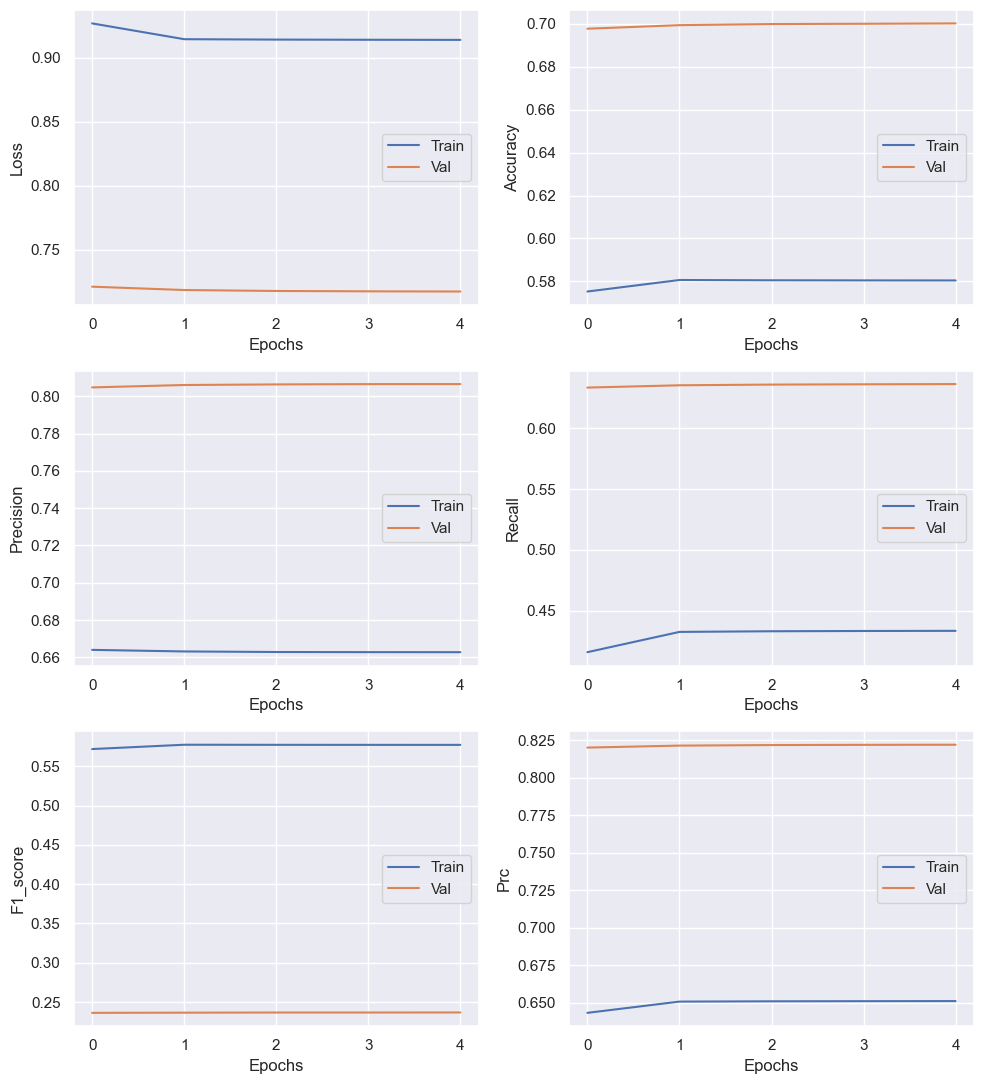

---- Last epoch loss ----
* Training:  0.914
* Validation:  0.717

---- Last epoch accuracy ----
* Training:  0.580
* Validation:  0.700

---- Last epoch precision ----
* Training:  0.663
* Validation:  0.807

---- Last epoch recall ----
* Training:  0.433
* Validation:  0.636

---- Last epoch f1_score ----
* Training:  0.577
* Validation:  0.237

---- Last epoch prc ----
* Training:  0.651
* Validation:  0.822



In [23]:
METRICS = ['accuracy', tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.F1Score(average='macro', name='f1_score'),
           tf.keras.metrics.AUC(name='prc', curve='PR')]

def train_and_evaluate_mcl(data='wildfire',
                       n_features = X_train_res_std.shape[1],
                       optimizer='Adam',
                       learning_rate=0.01,
                       batch_size = 4096,
                       metric=METRICS,
                       num_epochs=5):

  # Build the model.
    model = build_model_mcl(n_classes=4,
                        n_features = n_features,
                        optimizer=optimizer,
                        metric=metric,
                        learning_rate=learning_rate)

  # Select the dataset.
    if data == 'wildfire':
        pass
    
    else:
        raise 'Unsupported dataset: %s' %data

  # Train the model.
    print('Training the', data, 'model...')
    history = model.fit(
        x=X_train_res_std,
        y=Y_train_oh,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=[X_val_std, Y_val_oh],
        verbose=0)
    
    # Plot history
    plot_history_metrics(history)

    # Print last epoch metrics
    print_last_epoch_metrics(history)

    return model


# test run the function
model = train_and_evaluate_mcl()

#### Train model

Training the wildfire model...


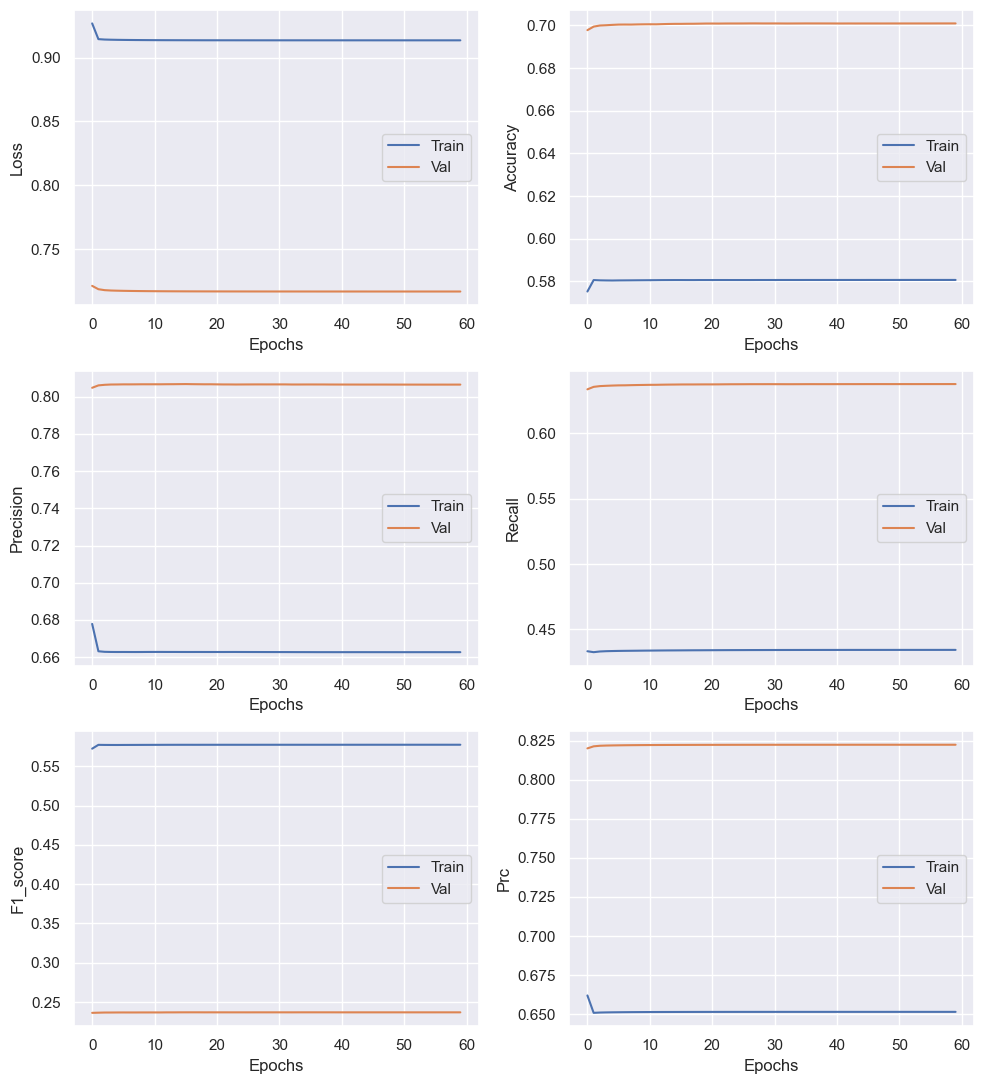

---- Last epoch loss ----
* Training:  0.913
* Validation:  0.717

---- Last epoch accuracy ----
* Training:  0.581
* Validation:  0.701

---- Last epoch precision ----
* Training:  0.663
* Validation:  0.806

---- Last epoch recall ----
* Training:  0.434
* Validation:  0.637

---- Last epoch f1_score ----
* Training:  0.578
* Validation:  0.237

---- Last epoch prc ----
* Training:  0.652
* Validation:  0.822



In [24]:
# conduct experiments and record results in an ablation table
model_exp = train_and_evaluate_mcl(learning_rate=0.01,
                                   batch_size=4096,
                                   num_epochs=60)

In [25]:
model_exp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │           420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,262 (4.93 KB)

 Trainable params: 420 (1.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 842 (3.29 KB)

In [26]:
# report the hyperparameter values for the prefered architecture configuration

print("""The hyperparameter values for prefered architecture configuration are:
      - optimizer: Adam
      - learning rate: 0.1
      - number of epochs: 60
      - batch_size: 4096
""")

The hyperparameter values for prefered architecture configuration are:
      - optimizer: Adam
      - learning rate: 0.1
      - number of epochs: 60
      - batch_size: 4096



In [27]:
# run the model once more using the preferred hyperparameter configuration

# define parameters
n_features = X_train_res_std.shape[1]
optimizer_preferred = 'Adam'
learning_rate_preferred = 0.1
num_epochs_preferred = 50
batch_size_preferred = 4096

# run the model
model_tf = build_model_mcl(n_classes=4,
                           n_features=n_features,
                           optimizer=optimizer_preferred,
                           metric=METRICS,
                           learning_rate=learning_rate_preferred)

model_fit_tf = model_tf.fit(x=X_train_res_std,
                            y=Y_train_oh,
                            epochs=num_epochs_preferred,
                            batch_size=batch_size_preferred,
                            validation_data=[X_val_std, Y_val_oh],
                            verbose=0)


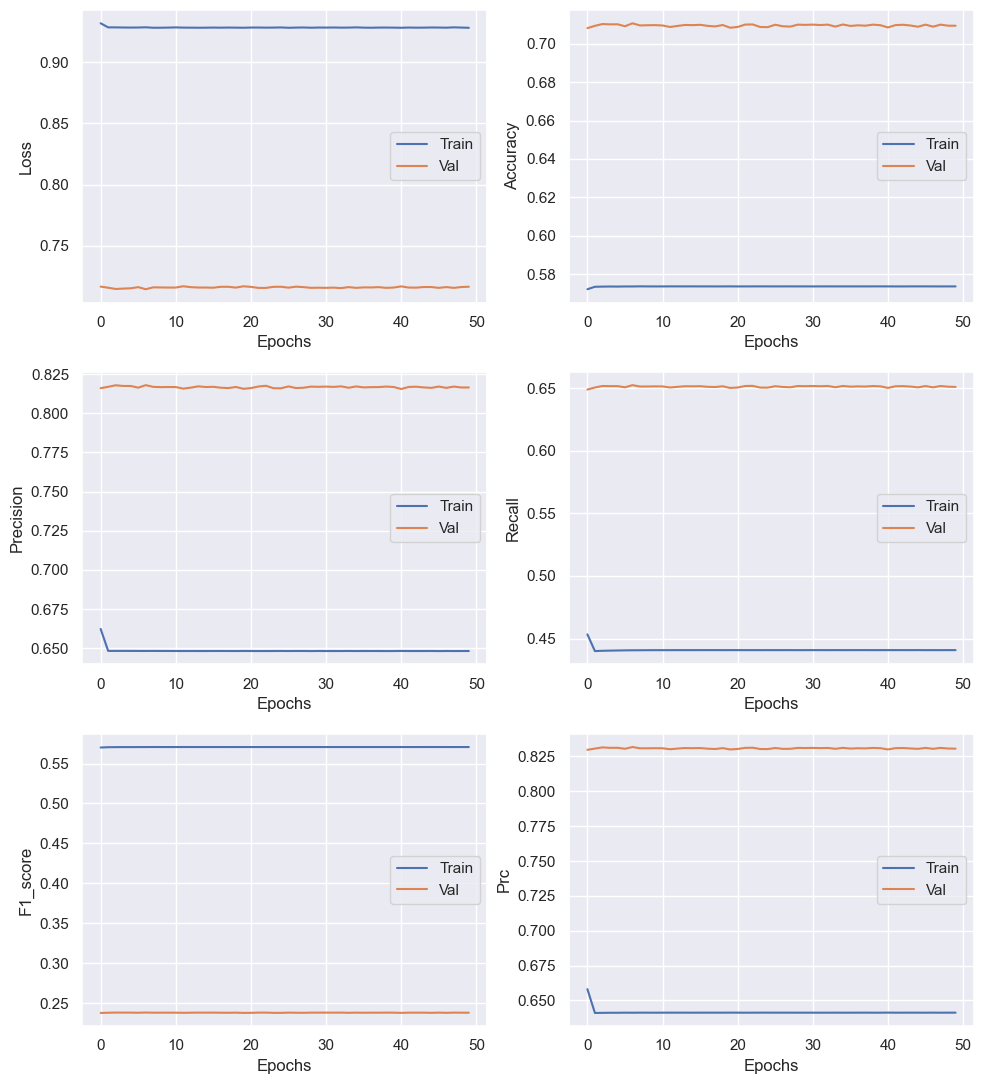

In [28]:
# plot history metrics
plot_history_metrics(model_fit_tf)

#### Evaluate

In [29]:
Y_val_pred_proba = model_tf.predict(X_val_std) # predicted probability 
Y_val_pred = np.argmax(Y_val_pred_proba, axis=1)

print(f"Shape of Y_val: {Y_val.shape}")
print(f"Shape of Y_val_pred: {Y_val_pred.shape}")

14391/14391 ━━━━━━━━━━━━━━━━━━━━ 3s 230us/step
Shape of Y_val: (460504,)
Shape of Y_val_pred: (460504,)


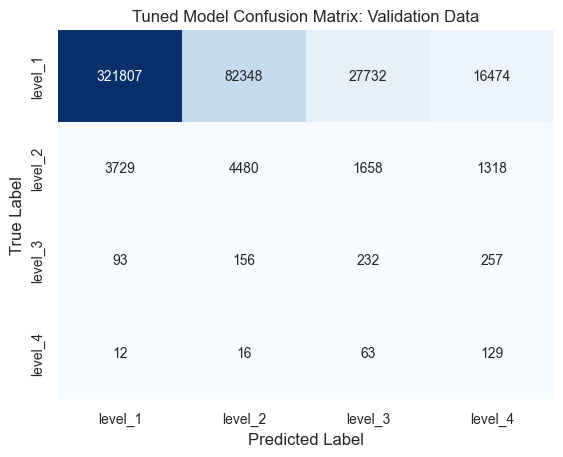

In [30]:
# plot the confusion matrix using (y_val, y_val_pred) data
target_labels = ['level_1', 'level_2', 'level_3', 'level_4']          

cf = tf.math.confusion_matrix(Y_val, Y_val_pred)
ax = sns.heatmap(cf, annot=True, fmt='d', cmap='Blues',
                 cbar=False,
                 annot_kws={'fontsize': 10},
                 xticklabels=target_labels,
                 yticklabels=target_labels)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel='Predicted Label', ylabel='True Label')
ax.set_title('Tuned Model Confusion Matrix: Validation Data')
plt.show()

In [31]:
def print_report(fitted_clf, X, Y, txt = 'Data', threshold=[0,0,0,0]):
    target_labels = ['level_1', 'level_2', 'level_3', 'level_4']
    Y_pred_proba = fitted_clf.predict(X)
    Y_pred = np.argmax(Y_pred_proba - threshold, axis=1)
    print(f"\n*** {txt} ***")
    print(classification_report(Y, Y_pred, target_names=target_labels, digits=5))

In [32]:
print_report(model_tf, X=X_train_res_std, Y=Y_train_resampled, txt="Multiclass Logistic (Training Data)")
print_report(model_tf, X=X_val_std, Y=Y_val, txt="Multiclass Logistic (Validation Data)")

168136/168136 ━━━━━━━━━━━━━━━━━━━━ 39s 229us/step

*** Multiclass Logistic (Training Data) ***
              precision    recall  f1-score   support

     level_1    0.70142   0.71817   0.70970   1345082
     level_2    0.55611   0.48310   0.51704   1345082
     level_3    0.45550   0.38358   0.41646   1345082
     level_4    0.56818   0.71892   0.63472   1345082

    accuracy                        0.57594   5380328
   macro avg    0.57030   0.57594   0.56948   5380328
weighted avg    0.57030   0.57594   0.56948   5380328

14391/14391 ━━━━━━━━━━━━━━━━━━━━ 3s 227us/step

*** Multiclass Logistic (Validation Data) ***
              precision    recall  f1-score   support

     level_1    0.98823   0.71774   0.83154    448361
     level_2    0.05149   0.40054   0.09126     11185
     level_3    0.00782   0.31436   0.01525       738
     level_4    0.00710   0.58636   0.01402       220

    accuracy                        0.70933    460504
   macro avg    0.26366   0.50475   0.23802    460